In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
# pd.options.mode.chained_assignment = None  # default='warn'
import datetime as dt
import os
import math
import numpy as np
import pickle
from tqdm import tqdm
import matplotlib.pyplot as plt
import osmnx as ox
from sklearn.cluster import KMeans
from sklearn_extra.robust import RobustWeightedKMeans
from sklearn_extra.cluster import KMedoids
from sklearn import svm
import networkx as nx
pd.set_option('display.max_columns', None)

In [ ]:
# Confirm directories are in place
TARGET_AREA = 'davidson'

if not os.path.exists(os.path.join(os.getcwd(), '../data', TARGET_AREA)):
    raise OSError("Must first download data, see README.md")
data_dir = os.path.join(os.getcwd(), '../data', TARGET_AREA)

if not os.path.exists(os.path.join(data_dir, 'ratings')):
    os.mkdir(os.path.join(data_dir, 'ratings'))
ratings_dir = os.path.join(data_dir, 'ratings')

if not os.path.exists(os.path.join(os.getcwd(), '../img')):
    raise OSError("Must first download data, see README.md")
img_dir = os.path.join(os.getcwd(), '../img')

In [ ]:
returned_trust_score = []
for loop run eeta: 
    for loop run T:
        returned_trust_score.apped( cal_trust_score())
# for the cross validation create a search space for K and eeta 
# where K is 
def cal_trust_score(file_path,k,eeta): 
    rating_A = pd.read_csv(file_path)
#     print(rating_A)
    l_original = rating_A.drop(rating_A.columns[0], axis=1)
#     print(l_original)
    N  = len(l_original)
    Window = len(l_original.columns)
    temp = np.zeros(shape=(N,Window))
    x = pd.DataFrame(temp)
    cw = x.copy()
    w = x.copy()
    
    K = 4# maximum rating level #these are parameters
    eeta = eeta; # these are paramters
    M_BR = 4 
    
    l1_original = l_original.apply(np.sort, axis = 1)
#     print(l1_original)
    for i in range(N):
        for j in range(Window):
            x.iloc[i,j] = 1 + ((K-1)*j)/Window
#     print(x)
    temp1 = np.zeros(shape=N)
    std_dr = pd.DataFrame(temp1)
    for i in range(N):
        std_dr.iloc[i] = np.std(l1_original[i])    
    for i in range(len(std_dr)):
        if int(std_dr.iloc[i]) == 0:
            std_dr.iloc[i] = np.mean(std_dr) 
#     print(std_dr)
    for i in range(N):
        for j in range(Window):         
            cw.iloc[i,j] = (1/(math.sqrt(2*3.1415)*std_dr.iloc[i,0]))*(math.exp((-1*math.pow((x.iloc[i,j]-M_BR),2))/(2*math.pow(std_dr.iloc[i,0],2))))
#     print(cw)  
    for i in range(N):
        for j in range(Window):
            w.iloc[i,j] = cw.iloc[i,j]/np.sum(cw.iloc[i,:])
#     print(w)  
    R = np.zeros(shape=N)
    for segment in range(N):
        temp2 = np.zeros(shape=(4,Window))
        I = pd.DataFrame(temp2)
        #creates the evasion discrete levels.
        for j in range(Window):
            if l_original.iloc[segment,j] == 1:
                I.iloc[0,j] = 1
            elif l_original.iloc[segment,j] == 2:
                I.iloc[1,j] = 1
            elif l_original.iloc[segment,j] == 3:
                I.iloc[2,j] = 1
            else:
                I.iloc[3,j] = 1
        temp3 = np.zeros(shape=4)
        wd = pd.DataFrame(temp3)
        for i in range(4):
            for j in range(Window):
                wd.iloc[i,0] = wd.iloc[i,0] + I.iloc[i,j]*w.iloc[segment,j]

        for i in range(4):
            R[segment] = R[segment] + (i+1)*wd.iloc[i,0]
#     print(R)
    TR = np.zeros(shape=N)
    for i in range(N):
        TR[i] = (1/math.pow(K,eeta))*(math.pow(R[i],eeta))
#     print(TR)
    return TR,rating_A.iloc[:, 0].tolist()


In [2]:
list_of_ratings_per_cluster_per_incident_dir  =  os.path.join(ratings_dir, 'LARGEWINDOW_100')
files_25_ratings = os.listdir(list_of_ratings_per_cluster_per_incident_dir)
print(len(files_25_ratings))

trust_score=[]
prediction =[] #0 means high trusted 1 means less trusted 
segment_list_per_cluster = []
dead_idx = []
for i, file_path in enumerate(files_25_ratings):
    fp = os.path.join(list_of_ratings_per_cluster_per_incident_dir, file_path)
    TR,list_segments = cal_trust_score(fp)
    trust_score.append(TR)
    segment_list_per_cluster.append(list_segments)
    print(TR)
    # kmeans = KMeans(n_clusters=2)
    kmeans = KMedoids(n_clusters=2, init='heuristic', method='pam', max_iter=1000)
    # kmeans = svm.OneClassSVM(kernel='rbf', gamma=0.00005) 
    # Change to k-medoids, k-means++, robust k-means, svm
    kmeans.fit(TR.reshape(-1,1))    
    y_kmeans = kmeans.predict(TR.reshape(-1,1))
    prediction.append(y_kmeans)
    print(y_kmeans)

NameError: name 'ratings_dir' is not defined

In [5]:
def get_neighboring_segments(L_XDSegID, cluster_list, segment, level=5, undirected=False):
    neighbor_df = {'XDSegID': [], 'level': []}
    done = []
    for l in range(level + 1):
        H = nx.ego_graph(L_XDSegID, n=segment, radius=l, undirected=undirected)
        for n in H.nodes:
            if n not in done:
                if n in cluster_list:
#                     print(n, l)
                    neighbor_df['XDSegID'].append(n)
                    neighbor_df['level'].append(l)
                    done.append(n)
    return pd.DataFrame(neighbor_df).sort_values(by='level')

In [6]:
if not os.path.exists(os.path.join(data_dir, 'segment_network_graphs')):
    os.mkdir(os.path.join(data_dir, 'segment_network_graphs'))
graphs_dir = os.path.join(data_dir, 'segment_network_graphs')
fp = os.path.join(graphs_dir, 'line_segment_graph.gml')
L_XDSegID = nx.read_gml(fp, destringizer=int)
print(nx.info(L_XDSegID))

MultiDiGraph with 6906 nodes and 15264 edges


/tmp/ipykernel_2725/3976196170.py:6: DeprecationWarning: info is deprecated and will be removed in version 3.0.

  print(nx.info(L_XDSegID))


In [7]:
fp_cluster = os.path.join(data_dir, "generated_clusters/optimized_clustering_0.7_0.85_maxr085_restricted.pkl")
print(fp_cluster)
with open(fp_cluster, 'rb') as handle:
    cluster_list = pickle.load(handle)

/media/seconddrive/Anomaly_Detection_2021/extension/../data/davidson/generated_clusters/optimized_clustering_0.7_0.85_maxr085_restricted.pkl


In [8]:
fp = os.path.join(data_dir, 'all_incidents_ground_truth.pkl')
all_incidents_gt = pd.read_pickle(fp)
all_incidents_gt = all_incidents_gt[all_incidents_gt['cluster_head'] != -1]

In [9]:
ground_truth_data_path  =  os.path.join(data_dir, "generated_clusters/maxr085_incident_ratios/incidents_GT")
files_GT = os.listdir(ground_truth_data_path)
incident_GT = []
i = 0
while i< len(files_GT):
    fp = os.path.join(ground_truth_data_path, files_GT[i])
    with open(fp, 'rb') as handle:
        incident_GT.append( pickle.load(handle))
    i+=1
incident_GT_Frame = pd.concat(incident_GT)

In [10]:
level = 4
neighbour_segments_per_incident_per_cluster = []
list_of_cluster = []
found = 0
for i in range(0,len(files_25_ratings)):
    cluster_head = files_25_ratings[i].split("_")[1]
    start = dt.datetime.strptime(files_25_ratings[i].split("_")[2], '%Y%m%d%H%M%S')
    month = start.month
    day = start.day
    list_of_cluster.append(cluster_head)
    
    incident_segment_frame = incident_GT_Frame[(incident_GT_Frame['cluster_head'] == int(cluster_head)) &\
                             ((incident_GT_Frame.index.month == int(month))&( incident_GT_Frame.index.day==int(day)))]
    if(len(incident_segment_frame) == 0): 
        continue
    found+=1
    segment_to_check = incident_segment_frame['XDSegID'].tolist()[0]
    neighbour_segments = get_neighboring_segments(L_XDSegID, cluster_list[int(cluster_head)], segment_to_check, level, undirected=True)
    neighbour_segments_per_incident_per_cluster.append(neighbour_segments)
found

100

In [34]:
success_rate_sum = 0
success_count = 0

false_positives = 0
detection_counts = 0

# for fI in tqdm(range(0,len(files_25_ratings))):
for fI in tqdm(range(2, 3)):
    TR_prediction = prediction[fI]
    neighbour_segments_frame =  neighbour_segments_per_incident_per_cluster[fI]
    neighbour_segments_list = neighbour_segments_frame['XDSegID'].tolist()
    segment_list = segment_list_per_cluster[fI]
    for i in range(0,len(TR_prediction)):
        if(TR_prediction[i] == 1 ):
            if(segment_list[i]  in neighbour_segments_list ):
                label = neighbour_segments_frame[neighbour_segments_frame['XDSegID']==segment_list[i]]['level'].tolist()[0]
                if((label == int(1))or(label == int(0))) :
                    success_count = success_count + 1
                    break
    break
print(success_count, success_rate_sum)

active_ratings = len(files_25_ratings)
avg_success_rate = success_count/(active_ratings)
print(avg_success_rate, active_ratings)

  0%|          | 0/1 [00:00<?, ?it/s]

1 0
0.01 100


# Identifying other metrics
* See lines `10-13`, I set it up as follows:
    * If segment is in `0` or `1` segment level AND prediction is equal to `1` => TP
    * If segment is in `0` or `1` segment level AND prediction is equal to `0` => FN
    * If segment is NOT in `0` or `1` segment level AND prediction is equal to `1` => FP
    * If segment is NOT in `0` or `1` segment level AND prediction is equal to `0` => TN
* Not sure if this the correct way to do it, our previous code only measures TP as:
    * If ANY segment is in 0 or 1 segment level AND prediction is equal to 1 count as 1 success and move on to next incident
    * `results_arr.sum()['OLD_TP'] / total_incident_ratings`

In [71]:
import random
results_arr = []
for fI in tqdm(range(len(files_25_ratings))):
    TR_prediction = prediction[fI]
    segment_list = segment_list_per_cluster[fI]
    pred_df = pd.DataFrame(np.column_stack((segment_list, TR_prediction)), columns=['XDSegID', 'pred'])
    neighbour_segments_frame =  neighbour_segments_per_incident_per_cluster[fI]
    pred_df = pd.merge(pred_df, neighbour_segments_frame, left_on='XDSegID', right_on='XDSegID', how='outer')
    pred_df = pred_df.fillna(neighbour_segments_frame.level.max() + 1).sort_values('level')
    
    TP = pred_df[(pred_df['level'].isin([0, 1])) & (pred_df['pred'] == 1)]
    FN = pred_df[(pred_df['level'].isin([0, 1])) & (pred_df['pred'] == 0)]
    FP = pred_df[(~pred_df['level'].isin([0, 1])) & (pred_df['pred'] == 1)]
    TN = pred_df[(~pred_df['level'].isin([0, 1])) & (pred_df['pred'] == 0)]
    
    OLD_TP = 0
    if len(TP) > 0:
        OLD_TP = 1

    # display(pred_df)
    results_arr.append([OLD_TP, len(TP), len(FP), len(TN), len(FN)])
    # break
results_arr = pd.DataFrame(results_arr, columns=['OLD_TP', 'TP','FP','TN','FN'])

# OLD_TP
results_arr.sum()['OLD_TP']/len(files_25_ratings)

100%|██████████| 100/100 [00:00<00:00, 374.39it/s]


0.81

In [50]:
# Proposed metrics
results_arr['precision'] = results_arr['TP'] / (results_arr['TP'] + results_arr['FP'])
results_arr['TPR'] = results_arr['TP'] / (results_arr['TP'] + results_arr['FN'])
results_arr['FPR'] = results_arr['FP'] / (results_arr['FP'] + results_arr['TN'])
results_arr['BAL_ACC'] = (results_arr['TPR'] + (1 - results_arr['FPR'])) / 2

In [56]:
FPR = results_arr['FP'].sum() / (results_arr['FP'].sum() + results_arr['TN'].sum())
TPR = results_arr['TP'].sum() / (results_arr['TP'].sum() + results_arr['FN'].sum())
BAL_ACC = (TPR + (1 - FPR)) / 2
TPR, FPR, BAL_ACC

(0.4691689008042895, 0.520618556701031, 0.4742751720516293)

<AxesSubplot:>

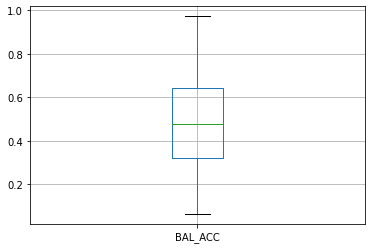

In [52]:
results_arr[['BAL_ACC']].boxplot()

In [ ]:
# Davidson: 0.79, 100 files
# Hamilton: 0.6464, 99 files
# Shelby:  0.6782, 87 files
# Knox: 0.68,100 files

# IGNORE BELOW

## Putting it all together for all cities

In [ ]:
counties = ['davidson', 'hamilton', 'knox', 'shelby']
cities = ['Nashville', 'Chattanooga', 'Knoxville', 'Memphis']
level = 4

def evaluate_ratings_for_county(TARGET_AREA):
    county_idx = counties.index(TARGET_AREA)
    city = cities[county_idx]
    if not os.path.exists(os.path.join(os.getcwd(), '../data', TARGET_AREA)):
        raise OSError("Must first download data, see README.md")
    data_dir = os.path.join(os.getcwd(), '../data', TARGET_AREA)

    if not os.path.exists(os.path.join(data_dir, 'ratings')):
        os.mkdir(os.path.join(data_dir, 'ratings'))
    ratings_dir = os.path.join(data_dir, 'ratings')
        
    if not os.path.exists(os.path.join(data_dir, 'segment_network_graphs')):
        os.mkdir(os.path.join(data_dir, 'segment_network_graphs'))
    graphs_dir = os.path.join(data_dir, 'segment_network_graphs')

    list_of_ratings_per_cluster_per_incident_dir  =  os.path.join(ratings_dir, 'LARGEWINDOW_100')
    files_25_ratings = os.listdir(list_of_ratings_per_cluster_per_incident_dir)

    trust_score=[]
    prediction =[] #0 means high trusted 1 means less trusted 
    segment_list_per_cluster = []
    for file_path in files_25_ratings:
        fp = os.path.join(list_of_ratings_per_cluster_per_incident_dir, file_path)
        TR,list_segments = cal_trust_score(fp)
        trust_score.append(TR)
        segment_list_per_cluster.append(list_segments)
        # kmeans = KMeans(n_clusters=2)
        # kmeans = RobustWeightedKMeans(n_clusters=2, weighting='mom', max_iter=300)
        # kmeans = KMedoids(n_clusters=2, init='heuristic', method='pam', max_iter=1000)
        # kmeans = KMedoids(n_clusters=2, init='k-medoids++', method='pam', max_iter=500)
        
        kmeans = svm.OneClassSVM(kernel='rbf', gamma=0.00005) 
        kmeans.fit(TR.reshape(-1,1))
        y_kmeans = kmeans.predict(TR.reshape(-1,1))
        prediction.append(y_kmeans)
        
    fp = os.path.join(graphs_dir, 'line_segment_graph.gml')
    L_XDSegID = nx.read_gml(fp, destringizer=int)

    ground_truth_data_path  =  os.path.join(data_dir, "generated_clusters/maxr085_incident_ratios/incidents_GT")
    files_GT = os.listdir(ground_truth_data_path)
    incident_GT = []
    i = 0
    while i < len(files_GT):
        fp = os.path.join(ground_truth_data_path, files_GT[i])
        with open(fp, 'rb') as handle:
            incident_GT.append( pickle.load(handle))
        i+=1
    incident_GT_Frame = pd.concat(incident_GT)

    fp_cluster = os.path.join(data_dir, "generated_clusters/optimized_clustering_0.7_0.85_maxr085_restricted.pkl")

    with open(fp_cluster, 'rb') as handle:
        cluster_list = pickle.load(handle)

    neighbour_segments_per_incident_per_cluster = []
    list_of_cluster = []
    for i in range(0, len(files_25_ratings)):
        cluster_head = files_25_ratings[i].split("_")[1]
        start = dt.datetime.strptime(files_25_ratings[i].split("_")[2], '%Y%m%d%H%M%S')
        month = start.month
        day = start.day
        list_of_cluster.append(cluster_head)
        
        incident_segment_frame = incident_GT_Frame[(incident_GT_Frame['cluster_head'] == int(cluster_head)) &\
                                ((incident_GT_Frame.index.month == int(month))&( incident_GT_Frame.index.day==int(day)))]
        if(len(incident_segment_frame) == 0): 
            continue
        segment_to_check = incident_segment_frame['XDSegID'].tolist()[0]
        neighbour_segments = get_neighboring_segments(L_XDSegID, cluster_list[int(cluster_head)], segment_to_check, level, undirected=True)
        neighbour_segments_per_incident_per_cluster.append(neighbour_segments)
        
    success_rate_sum = 0
    success_count = 0
    for fI in range(0,len(files_25_ratings)):
        TR_prediction = prediction[fI]
        neighbour_segments_frame =  neighbour_segments_per_incident_per_cluster[fI]
        neighbour_segments_list = neighbour_segments_frame['XDSegID'].tolist()
        segment_list = segment_list_per_cluster[fI]
        for i in range(0,len(TR_prediction)):
            if(TR_prediction[i] == 1 ):
                if(segment_list[i]  in neighbour_segments_list ):
                    label = neighbour_segments_frame[neighbour_segments_frame['XDSegID']==segment_list[i]]['level'].tolist()[0]
                    if((label == int(1))or(label == int(0))) :
                        success_count = success_count + 1
                        break

    avg_success_rate = success_count/(len(files_25_ratings))
    print(f"{city},{avg_success_rate:.4f}")
    return city, avg_success_rate

In [ ]:
res_df_arr = []
runs = 5
for run in range(runs):
    city_arr = []
    avg_success_rate_arr = []
    for county in counties:
        city, avg_success_rate = evaluate_ratings_for_county(county)
        city_arr.append(city)
        avg_success_rate_arr.append(avg_success_rate)
    results = np.column_stack(([run]*len(city_arr), city_arr, avg_success_rate_arr))
    results = pd.DataFrame(results, columns=['run', 'city', 'score'])
    res_df_arr.append(results)
results_df = pd.concat(res_df_arr)

In [ ]:
# fp = os.path.join(data_dir, 'svm_evaluation_ratings_for_county.pkl')
# results_df.to_pickle(fp)
# results_df

In [ ]:
# fp = os.path.join(data_dir, 'evaluation_ratings_for_county.pkl')
# results_df = pd.read_pickle(fp)
# results_df

In [ ]:
ax = pd.pivot_table(results_df, values = 'score', index=['run'], columns = 'city').boxplot()
ax.set_ylim(0.0, 1.1)
ax.set_xlabel('City')
ax.set_ylabel('Segment Level Detection Accuracy')
fp = os.path.join('../img', 'svm_segment_level_detection_accuracy.png')
plt.savefig(fp, dpi=200, bbox_inches='tight')

# Visualizing models

In [ ]:
if not os.path.exists(os.path.join(os.getcwd(), '../data')):
    raise OSError("Must first download data, see README.md")
data_dir = os.path.join(os.getcwd(), '../data')

In [ ]:
## Plotting different clustering models
model_evals = ['kmeans_evaluation_ratings_for_county.pkl',
               'kmeanspp_evaluation_ratings_for_county.pkl',
               'kmedoids_evaluation_ratings_for_county.pkl',
               'robust_evaluation_ratings_for_county.pkl',
               'svm_evaluation_ratings_for_county.pkl']

markers = ['o', 's', '^', 'x', '*']
fig, ax = plt.subplots()
results_arr = []
for i, model_eval in enumerate(model_evals):
    fp = os.path.join(data_dir, model_eval)
    df = pd.read_pickle(fp)
    df = pd.pivot_table(df, values='score', columns='city', index='run')
    print(df.max().tolist())
    results_arr.append(df.max().tolist())
    # ax.plot(df.max(), marker=markers[i], label=model_eval.split("_")[0])
# ax.legend()
df = pd.DataFrame(results_arr, columns=df.columns)
df.boxplot(ax=ax)
ax.set_ylim(0.0, 1.1)

fp = os.path.join(data_dir, 'kmedoids_evaluation_ratings_for_county.pkl')
df = pd.read_pickle(fp)
df = pd.pivot_table(df, values='score', columns='city', index='run')
# ax.plot(df.iloc[0].tolist(), marker='o')
# df.plot(ax=ax)

ax.set_ylim(0.0, 1.1)
ax.set_xlabel('Cities')
ax.set_ylabel('Segment Level Detection Accuracy')
fp = os.path.join('../img', 'segment_level_detection_accuracy.png')
plt.savefig(fp, dpi=200, bbox_inches='tight', facecolor='white', transparent=False)

# Below not needed 

In [ ]:
for fI in range(0,len(files_25_ratings)):
    print('*************',list_of_cluster[fI],'***************')
    TC = trust_score[fI]
    TR_prediction = prediction[fI]
    segment_list = segment_list_per_cluster[fI]
    for i in range(0,len(TR_prediction)):
        if(TR_prediction[i] == 1 ):
            if(segment_list[i]  in neighbour_segments_list ):
                label = neighbour_segments_frame[neighbour_segments_frame['XDSegID']==segment_list[i]]['level'].tolist()[0]
                print("segment: ",segment_list[i]," Trust Score: ",TC[i],' Level: ',label)


In [ ]:
success_rate_sum = 0
for fI in range(0,len(files_25_ratings)):
    TC = trust_score[fI]
    TR_prediction = prediction[fI]
    print('*************',list_of_cluster[fI],'***************')

#     print(TR_prediction)
    neighbour_segments_frame =  neighbour_segments_per_incident_per_cluster[fI]
    neighbour_segments_list = neighbour_segments_frame['XDSegID'].tolist()
#     print(neighbour_segments_list)
    segment_list = segment_list_per_cluster[fI]
#     print(len(segment_list))
#     print(len(TR_prediction))
#     print( neighbour_segments_frame[neighbour_segments_frame['level']== 1])
    actual_affected_segment_count = neighbour_segments_frame[neighbour_segments_frame['level']== 1]['XDSegID'].count()
#     print("Actual affected segment count for ",fI,"-th Cluster is: ",actual_affected_segment_count)
    if(actual_affected_segment_count == 0):
        print(fI,"th segment has count zero",actual_affected_segment_count)
    predicted_affected_segment_count = 0
    for i in range(0,len(TR_prediction)):
        if(TR_prediction[i] == 1 ):
            if(segment_list[i]  in neighbour_segments_list ):
#                 print(neighbour_segments_frame[neighbour_segments_frame['XDSegID']==segment_list[i]]['level'].tolist())
                label = neighbour_segments_frame[neighbour_segments_frame['XDSegID']==segment_list[i]]['level'].tolist()[0]
#                 print(segment_list[i],':',label)
                print("segment: ",segment_list[i]," Trust Score: ",TC[i],' Level: ',label)

                if(label == int(1)):
                    predicted_affected_segment_count = predicted_affected_segment_count + 1
    success_rate = predicted_affected_segment_count/actual_affected_segment_count
    if(math.isnan(success_rate) == False):
        success_rate_sum = success_rate_sum + success_rate
        print(success_rate,predicted_affected_segment_count,actual_affected_segment_count)
#     break
# print(success_rate_sum)
avg_success_rate = success_rate_sum/(len(files_25_ratings))
print(avg_success_rate)

In [ ]:
18/25

In [ ]:
check the trust score that has level 0,1,2 with level 3,4 